<div align="center">
    <font color="0F5298" size="7">
        Deep Learning <br>
    </font>
    <font color="2565AE" size="5">
        CE Department <br>
        Spring 2024 - Prof. Soleymani Baghshah <br>
    </font>
    <font color="3C99D" size="5">
        HW2 Practical <br>
    </font>
    <font color="696880" size="5">
        30 Points
    </font>
</div>


In [ ]:
FULLNAME = 'YOUR NAME'
STD_ID = 'YOUR ID'

# Q3. License Plate Detection and Recognition (30 points)

## Introduction

In this assignment, we will build a two-stage license plate recognition system:

1. First stage: Detect license plates in an image (license plate detection / LPD)
2. Second stage: Recognize characters within the detected license plate (license plate recognition / LPR)

This approach is not explicitly an OCR (Optical Character Recognition), but it has some similarities with important differences. Unlike general OCR which often relies on sequence models (like RNNs or Transformers) to capture language context, license plates have a fixed format with predictable structure. This allows us to use multi-class classification or object detection models for it - first to locate plates, then to locate and classify individual characters.

## Background on YOLO (You Only Look Once)

### Evolution of Object Detection

Object detection has evolved significantly over the years:
- **Two-stage detectors** (like R-CNN family): First propose regions, then classify them
- **Single-stage detectors** (like YOLO and SSD): Predict bounding boxes and classes in a single forward pass

YOLO revolutionized object detection by framing it as a regression problem rather than a classification problem. Instead of generating region proposals and then classifying each region (a slow, two-stage process), YOLO divides the image into a grid and predicts bounding boxes and class probabilities directly in a single forward pass.

### YOLO Architecture

![YOLO Architecture](https://velog.velcdn.com/images/hunniee_j/post/cbd3888c-8b75-4325-988f-eadaded84232/image.JPG)

The basic YOLO approach:

1. **Grid Division**: Divide the image into an S×S grid
2. **Bounding Box Prediction**: Each grid cell predicts B bounding boxes, each with 5 parameters (x, y, w, h, confidence)
3. **Class Prediction**: Each grid cell also predicts class probabilities
4. **Non-Maximum Suppression**: Remove overlapping boxes with lower confidence scores

for a brief explanation of Object detection from RCNN to yolo version8 visit this [link](https://youtube.com/playlist?list=PL8VDJoEXIjppNvOzocFbRciZBrtSMi81v&si=qIh3VagQOzgWZ7Go)

the latest version of yolo is YOLO 12 and [here](https://docs.ultralytics.com/models/yolo12/) is Ultralytics documentation about it (all models of yolo family available in ultralytics has accessible documentation  [here](https://docs.ultralytics.com/models/) too.)


## Ultralytics Framework

Ultralytics is a Python library that makes it easy to train, test, and deploy YOLO models. Key features:

- **Easy to use API**: Simple Python API for training, validation, and inference
- **Pre-trained models**: Various pre-trained models of different sizes (nano to extra large)
- **Export options**: Export to various formats (ONNX, TFLite, CoreML, etc.)
- **Multi-task learning**: Support for object detection, segmentation, and pose estimation



## Assignment Tasks

In this assignment, you will:

1. Train a YOLO model for license plate detection on LPD dataset
2. Train a CNN model for license plate recognition within LPR license plates (7 digit + 1 letter classificaiton task)
3. Create an end-to-end pipeline that connects step 1 with 2
4. Evaluate the performance of your system on the test data


The dataset are available in [this](https://drive.google.com/drive/folders/1StRhbI28MaoiuXqA2rG5vGqKG5K2bMW6?usp=sharing) drive folder. let's dive into it!



In [ ]:
#Necessary installations

%pip install -q ultralytics
%pip install -q matplotlib opencv-python pyyaml

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#imports

import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random
import pandas as pd
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display
import pandas as pd
import torch.utils.data as data
import torch
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import cv2


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
BASE_PATH = '/home/physical_security/Projects/__Amir__'

### 1. LPD - YOLO

In [ ]:
LPD_RELATIVE_PATH = 'IR-LPD'
LPD_DIR = f'{BASE_PATH}/{LPD_RELATIVE_PATH}'

images_dir = os.path.join(LPD_DIR, 'images')
labels_dir = os.path.join(LPD_DIR, 'labels')

In [ ]:
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

print(f"Dataset contains {len(image_files)} images and {len(label_files)} labels")


objects_count = 0
for label_file in [os.path.join(labels_dir, f) for f in label_files]:
    with open(label_file, 'r') as f:
        objects_count += len(f.readlines())

print(f"Total license plates in dataset: {objects_count}")
print(f"Average plates per image: {objects_count / max(1, len(image_files)):.2f}")

Dataset contains 6252 images and 6252 labels
Total license plates in dataset: 7257
Average plates per image: 1.16


<font color="orange">
1. What is the structure of YOLO's label files (`.txt`), and why are bounding box coordinates normalized?  
<br>2. How does the YAML configuration file in YOLO define a dataset, and what role does the `nc` (number of classes) parameter play?  
<br>3. Why does YOLO use a grid system for predictions, and how does it handle multiple objects in a single grid cell?  
</font>


In [ ]:
# you must create a yaml file there is just one class object detection and you must split the dataset into two parts (80%-20% for train and val)
# the executed result of cell is belong to train = val = all data for better understanding about the YOLO results.


YAML_PATH =  os.path.join(LPD_DIR, 'data.yaml')

In [ ]:
VERSION = '?'
MODEL_SIZE = 'n'  # Options: n, s, m, l, x
EPOCHS = 20
IMGSZ = 640
BATCH = 16
DEVICE = '0'

<font color="orange">
Compare the architectural and functional advancements in YOLO versions 8 through 12. Specifically:  

1. **YOLOv8**:  
   - What was the motivation behind adopting an anchor-free design, and how did this impact training complexity and performance?  
   - How did the integration of CSPDarknet and PANet improve feature extraction and multi-scale detection compared to earlier versions?  

2. **YOLOv9 (Hypothetical/Unofficial)**:  
   - If YOLOv9 introduced dynamic label assignment, how does this differ from static assignment in YOLOv8, and what are the implications for model accuracy and convergence speed?  
   - What role might lightweight model variants (e.g., YOLOv9n) play in edge-device deployment, and how were they optimized for resource-constrained environments?  

3. **YOLOv10**:  
   - How did hybrid loss functions (e.g., combining CIoU and focal loss) enhance the training process, and what challenges in object detection were they designed to address?  
   - What advancements in model pruning and quantization were introduced, and how did these techniques reduce model size without compromising accuracy?  

4. **YOLOv11**:  
   - In what ways did self-calibrated convolutions improve feature extraction, and how do they compare to traditional convolutional layers in terms of computational efficiency and accuracy?  
   - How did the introduction of multi-task learning (e.g., joint object detection and segmentation) expand the capabilities of YOLOv11, and what new applications does this enable?  

5. **YOLOv12**:  
   - What benefits does the integration of transformer-based modules bring to YOLOv12, and how does this hybrid architecture balance the strengths of CNNs and transformers?  
   - How does uncertainty estimation in YOLOv12 improve the reliability of predictions, particularly in safety-critical applications like autonomous driving or medical imaging?  
   - Discuss the role of domain adaptation techniques in YOLOv12 and how they address challenges like dataset bias or environmental variability.  

Based on these advancements, which version would you recommend for this aplication, and why?  
</font>

In [ ]:
LPD_model = 'todo'

In [ ]:

print(f"Starting YOLO{VERSION}{MODEL_SIZE} training for {EPOCHS} epochs...")

#todo

print("Training complete! Model saved to model/LPD folder.")

Starting YOLO12n training for 20 epochs...
Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40444MiB)
engine/trainer: task=detect, mode=train, model=../model/yolo12n.pt, data=/home/physical_security/Projects/__Amir__/IR-LPD/data.yaml, epochs=20, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=../model/LPD, name=yoloV12n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning /home/physical_security/Projects/__Amir__/IR-LPD/labels.cache... 6252 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6252/6252 [00:00<?, ?it/s]
val: Scanning /home/physical_security/Projects/__Amir__/IR-LPD/labels.cache... 6252 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6252/6252 [00:00<?, ?it/s]


Plotting labels to ../model/LPD/yoloV12n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ../model/LPD/yoloV12n
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.41G      1.075     0.9683     0.9769         40        640: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]


                   all       6252       7257      0.925      0.852      0.902      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.88G      1.152      0.819      1.009         28        640: 100%|██████████| 391/391 [00:56<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.19it/s]


                   all       6252       7257      0.922      0.873      0.922      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.88G      1.141      0.759      1.012         35        640: 100%|██████████| 391/391 [00:56<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.28it/s]


                   all       6252       7257      0.929      0.889      0.933      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.88G      1.094     0.7013     0.9979         20        640: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.19it/s]


                   all       6252       7257      0.938      0.898      0.942      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.88G      1.052     0.6584     0.9823         27        640: 100%|██████████| 391/391 [00:55<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.41it/s]


                   all       6252       7257      0.926      0.902      0.936      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.88G      1.021     0.6236     0.9713         29        640: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.28it/s]


                   all       6252       7257      0.944      0.904      0.948      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.88G     0.9908     0.5955     0.9613         21        640: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.20it/s]


                   all       6252       7257      0.934      0.906      0.952      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.88G     0.9634     0.5814     0.9528         14        640: 100%|██████████| 391/391 [00:56<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:24<00:00,  8.01it/s]


                   all       6252       7257      0.931      0.916      0.952      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.88G     0.9582     0.5645     0.9502         28        640: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:24<00:00,  8.14it/s]


                   all       6252       7257      0.931       0.91      0.954      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.88G     0.9386     0.5471     0.9505         27        640: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.33it/s]


                   all       6252       7257      0.935      0.914      0.952      0.693
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.88G     0.9126     0.5312     0.9443         15        640: 100%|██████████| 391/391 [00:57<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.19it/s]


                   all       6252       7257      0.943      0.909      0.957      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.88G     0.8963     0.5094     0.9398         12        640: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.38it/s]


                   all       6252       7257      0.941      0.923      0.962      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.88G     0.8795     0.4935     0.9332         12        640: 100%|██████████| 391/391 [00:53<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.44it/s]


                   all       6252       7257      0.939      0.929      0.966      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.88G     0.8473     0.4825      0.926         14        640: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:24<00:00,  8.16it/s]


                   all       6252       7257      0.946      0.918      0.966      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.88G      0.848     0.4694     0.9224         13        640: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.34it/s]


                   all       6252       7257      0.946      0.916      0.964      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.88G     0.8383     0.4557     0.9215         19        640: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.36it/s]


                   all       6252       7257      0.951      0.915      0.968      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.88G     0.8109     0.4435     0.9089         12        640: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]


                   all       6252       7257      0.941      0.928       0.97      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.88G     0.7985     0.4262      0.907         14        640: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:24<00:00,  8.13it/s]


                   all       6252       7257      0.949      0.928      0.972      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.88G      0.788     0.4188     0.9043         12        640: 100%|██████████| 391/391 [00:55<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]


                   all       6252       7257      0.953       0.93      0.973      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.88G     0.7717     0.4077     0.8956         12        640: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:23<00:00,  8.29it/s]


                   all       6252       7257      0.944      0.937      0.974       0.77

20 epochs completed in 0.444 hours.
Optimizer stripped from ../model/LPD/yoloV12n/weights/last.pt, 5.5MB
Optimizer stripped from ../model/LPD/yoloV12n/weights/best.pt, 5.5MB

Validating ../model/LPD/yoloV12n/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40444MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 196/196 [00:25<00:00,  7.70it/s]


                   all       6252       7257      0.944      0.937      0.974       0.77
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to ../model/LPD/yoloV12n
Training complete! Model saved to model/LPD folder.


Testing model on sample images...

image 1/1 /home/physical_security/Projects/__Amir__/IR-LPD/images/002082.jpg: 640x480 1 license_plate, 14.8ms
Speed: 2.0ms preprocess, 14.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


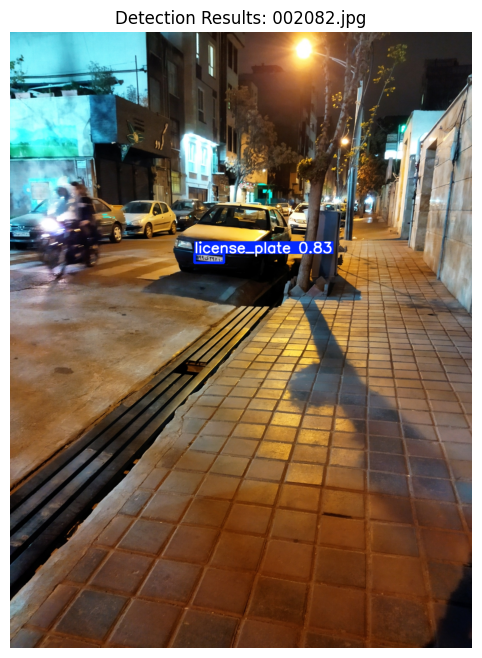


image 1/1 /home/physical_security/Projects/__Amir__/IR-LPD/images/004839.jpg: 640x384 1 license_plate, 25.3ms
Speed: 1.7ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


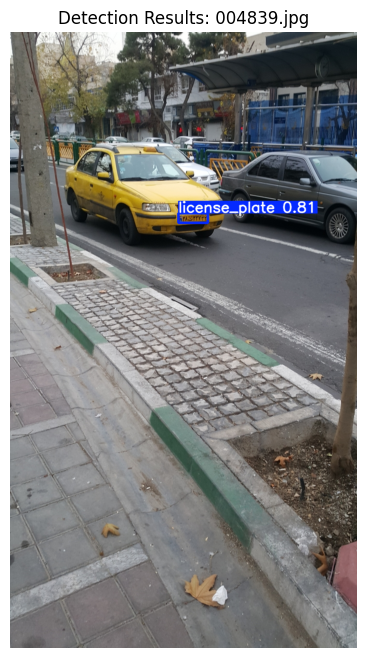


image 1/1 /home/physical_security/Projects/__Amir__/IR-LPD/images/001367.jpg: 384x640 (no detections), 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


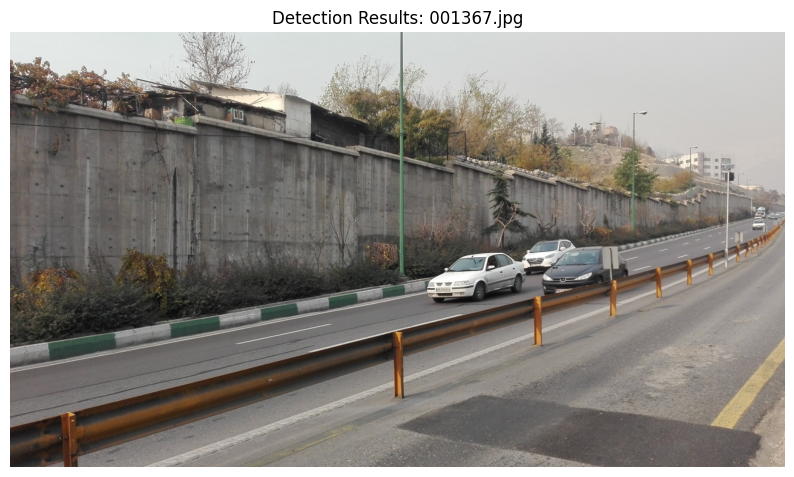


image 1/1 /home/physical_security/Projects/__Amir__/IR-LPD/images/004582.jpg: 640x384 1 license_plate, 20.7ms
Speed: 2.1ms preprocess, 20.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


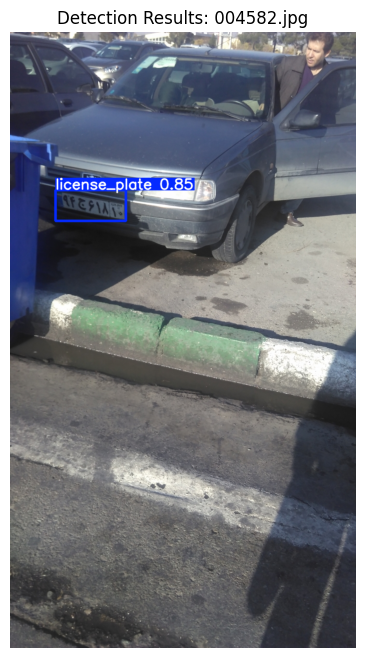


image 1/1 /home/physical_security/Projects/__Amir__/IR-LPD/images/000931.jpg: 448x640 1 license_plate, 88.7ms
Speed: 2.5ms preprocess, 88.7ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


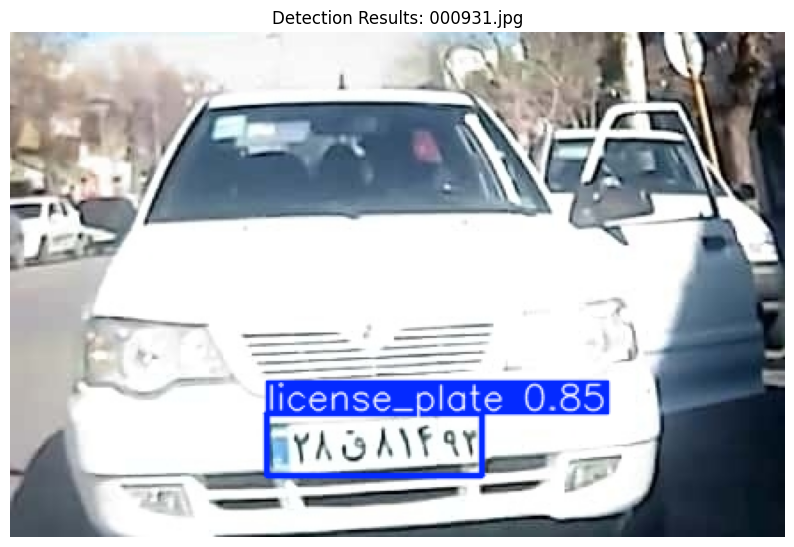

In [ ]:
%matplotlib inline

print("Testing model on sample images...")
for img_file in random.sample(image_files, 5):
    img_path = os.path.join(images_dir, img_file)

    #todo

### 2. LPR - CNN

In [ ]:
LPR_RELATIVE_PATH = 'IR-LPR'

df = pd.read_csv(f'{BASE_PATH}/{LPR_RELATIVE_PATH}/valid_samples.csv')
df = df.sample(n=22000, random_state=42)

In [ ]:
digit_vocabulary = "0123456789"
persian_letters = "آ ب پ ت ث ج چ ح خ د ذ ر ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن و ه ی".split()


digit_to_idx = {char: idx for idx, char in enumerate(digit_vocabulary)}
letter_to_idx = {char: idx for idx, char in enumerate(persian_letters)}
idx_to_digit = {idx: char for idx, char in enumerate(digit_vocabulary)}
idx_to_letter = {idx: char for idx, char in enumerate(persian_letters)}


persian_to_english_digits = {
    '۰': '0', '۱': '1', '۲': '2', '۳': '3', '۴': '4',
    '۵': '5', '۶': '6', '۷': '7', '۸': '8', '۹': '9'
}

persian_letter_normalization = {
    "الف": "آ",
    "ا" : "آ",
    "ژ (معلولین و جانبازان)": "ژ",
    "ه‍" : "ه"
}



def translate(label):

    first_two_digits = ''.join([persian_to_english_digits.get(char, char) for char in label[:2]])
    persian_letter = label[2]
    remaining_digits = ''.join([persian_to_english_digits.get(char, char) for char in label[3:]])
    return first_two_digits + persian_letter + remaining_digits


def preprocess_sample(image_path, label , full_transform=True, log=False, dir_path = BASE_PATH , relative_path= f'{LPR_RELATIVE_PATH}/detections', language='en'):

    if language == 'fa' :
      label = translate(label)

    elif language != 'en':
          raise Exception('Un-supported language!')

    path = f'{dir_path}/{relative_path}'

    train_transform = transforms.Compose([
        #todo
        transforms.ToTensor()
    ])

    test_transform = transforms.Compose([
        # todo
        transforms.ToTensor(),
    ])




    transform = train_transform if full_transform else test_transform
    image = Image.open(f'{path}/{image_path}').convert("RGB")
    image = transform(image)


    for key, value in persian_letter_normalization.items():
        label = label.replace(key, value)



    if log:
      print(label)

      for i , c in enumerate(label):
        if c in persian_letters:
          c = '*'
        print(f"{i}:{c}", end=' | ')

      print()


    digits = [digit_to_idx[char] for char in label if char.isdigit()]
    letter = letter_to_idx[label[2]]

    return image, digits, letter

In [ ]:
class PLPRDataset(data.Dataset):
    def __init__(self, df , split='train',dir_path=BASE_PATH,relative_path = f'{LPR_RELATIVE_PATH}/detections', language='en'):
        self.df = df
        self.full_transform = True if split == 'train' else False
        self.dir_path = dir_path
        self.relative_path = relative_path
        self.language = language

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # todo

In [ ]:
class FCNPLPRModel(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0"):
        super(FCNPLPRModel, self).__init__()

        # todo

    def forward(self, x):
        # todo
        digit_outputs , letter_output = None
        #digit_outputs  -> [batch_size, 7, 10]
        #letter_output -> [batch_size, num_persian_letters]

        return digit_outputs, letter_output

In [ ]:
learning_rate = 4e-4
batch_size = 32

In [ ]:
dataset = PLPRDataset(df)
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        # persistent_workers=True
)

In [ ]:
LPR_model = FCNPLPRModel().to(device)
digit_criterion = nn.CrossEntropyLoss()
letter_criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.AdamW(LPR_model.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.05,
    threshold_mode='rel',
    verbose=True
)

/home/physical_security/Projects/__Amir__/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def decode_predictions(digit_outputs, letter_output):
    digit_predictions = torch.argmax(digit_outputs, dim=2)  # [batch_size, 7]
    batch_size = digit_predictions.size(0)

    digits = []
    for b in range(batch_size):  # Iterate over batch
        sample_digits = []
        for i in range(7):  # Iterate over 7 digits
            try:
                sample_digits.append(idx_to_digit[digit_predictions[b][i].item()])
            except KeyError as e:
                print(f"KeyError: {e} (digit_predictions[{b}][{i}] = {digit_predictions[b][i].item()})")
                sample_digits.append("?")  # Use a placeholder for invalid indices
        digits.append(sample_digits)

    letter_prediction = torch.argmax(letter_output, dim=1)  # [batch_size]
    letters = []
    for b in range(batch_size):
        try:
            letters.append(idx_to_letter[letter_prediction[b].item()])
        except KeyError as e:
            print(f"KeyError: {e} (letter_prediction[{b}] = {letter_prediction[b].item()})")
            letters.append("?")  # Use a placeholder for invalid indices

    labels = []
    for b in range(batch_size):
        label = "".join(digits[b][:2]) + letters[b] + "".join(digits[b][2:])
        labels.append(label)

    return labels



def evaluate_misclassification(gt, pred):
    assert len(gt) == len(pred), "GT and Pred must have the same length."

    # Collect misclassified characters
    misclassified = []
    char_error_count = 0

    for i, (gt_char, pred_char) in enumerate(zip(gt, pred)):
        if gt_char != pred_char:
            misclassified.append(f"{gt_char} with {pred_char} at pos {i}")
            char_error_count += 1

    # Format the output
    misclassified_str = " , ".join(misclassified) if misclassified else "None"
    result = (f"GT: {gt} | Pred: {pred} | "
              f"Misclassified: {misclassified_str} | "
              f"Char error count: {char_error_count}")

    return result , char_error_count





def calculate_accuracy(model, df, device, dir_path=BASE_PATH, relative_path=f'{LPR_RELATIVE_PATH}/detections', language='en', log=False , cer = False):
    model.eval()
    FP= []
    CE = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df)):
            image_path = row["image_path"]
            label = row["label"]
            try:
                image, true_digits, true_letter = preprocess_sample(image_path, label, full_transform=False, dir_path=dir_path, relative_path=relative_path, language=language)

            except Exception as e:
                print(f"Error processing {image_path}: {e}")
                continue
            true_label = "".join([digit_vocabulary[d] for d in true_digits[:2]]) \
                         + persian_letters[true_letter] \
                         + "".join([digit_vocabulary[d] for d in true_digits[2:]])
            image = image.unsqueeze(0).to(device)
            digit_outputs, letter_output = model(image)

            predicted_labels = decode_predictions(digit_outputs, letter_output)

            if predicted_labels[0] == true_label:
                correct += 1
            elif log:
                report , char_error_count = evaluate_misclassification(true_label,predicted_labels[0])
                CE += char_error_count
                FP.append(report)
            total += 1


    accuracy = correct / total * 100

    if cer:
        print(f'CER: {100* CE/(8*df.shape[0]): .4f}%')

    if log:
         for false_positive in FP:
            print(false_positive)



    return accuracy

In [ ]:
full_df = pd.read_csv(f'{BASE_PATH}/IR-LPR/valid_samples.csv')
test_df = full_df.loc[~full_df.index.isin(df.index)]


In [ ]:
best_accuracy = 85.0
optimal_weights = None
num_epochs = 10


for epoch in range(num_epochs):
    LPR_model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, digit_targets, letter_targets in progress_bar:
        images = images.to(device)
        digit_targets = digit_targets.to(device)
        letter_targets = letter_targets.to(device)

        # Forward pass
        digit_outputs, letter_output = LPR_model(images)

        digit_loss = 0
        for i in range(7):
            digit_loss += digit_criterion(digit_outputs[:, i, :], digit_targets[:, i])
        letter_loss = letter_criterion(letter_output, letter_targets)
        loss = digit_loss + letter_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    LPR_model.eval()
    accuracy = calculate_accuracy(
        LPR_model,
        test_df,
        device,
        relative_path= f'{LPR_RELATIVE_PATH}/detections',
        language='en'
    )
    print(f"Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

    scheduler.step(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        optimal_weights = LPR_model.state_dict()  # Save the current model weights
        print(f"New best accuracy: {best_accuracy:.2f}%. Saving model weights.")
        torch.save(LPR_model.state_dict(), f'{BASE_PATH}/model/PLPR-CNN.pth')

if optimal_weights is not None:
    LPR_model.load_state_dict(optimal_weights)
    print("Loaded optimal weights into the model.")

Epoch 1/10, Average Loss: 10.3349


100%|██████████| 2561/2561 [01:06<00:00, 38.74it/s]


Accuracy after Epoch 1: 62.71%


Epoch 2/10, Average Loss: 3.5181


100%|██████████| 2561/2561 [01:10<00:00, 36.49it/s]


Accuracy after Epoch 2: 82.51%


Epoch 3/10, Average Loss: 2.4628


100%|██████████| 2561/2561 [01:08<00:00, 37.66it/s]


Accuracy after Epoch 3: 86.68%
New best accuracy: 86.68%. Saving model weights.


Epoch 4/10, Average Loss: 2.0576


100%|██████████| 2561/2561 [01:04<00:00, 39.59it/s]


Accuracy after Epoch 4: 89.54%
New best accuracy: 89.54%. Saving model weights.


Epoch 5/10, Average Loss: 1.5330


100%|██████████| 2561/2561 [01:01<00:00, 41.53it/s]


Accuracy after Epoch 5: 91.29%
New best accuracy: 91.29%. Saving model weights.


Epoch 6/10, Average Loss: 1.3846


100%|██████████| 2561/2561 [01:36<00:00, 26.48it/s]


Accuracy after Epoch 6: 91.60%
New best accuracy: 91.60%. Saving model weights.


Epoch 7/10, Average Loss: 1.2921


100%|██████████| 2561/2561 [01:48<00:00, 23.50it/s]


Accuracy after Epoch 7: 92.15%
New best accuracy: 92.15%. Saving model weights.


Epoch 8/10, Average Loss: 1.1066


100%|██████████| 2561/2561 [01:56<00:00, 21.99it/s]


Accuracy after Epoch 8: 92.42%
New best accuracy: 92.42%. Saving model weights.


Epoch 9/10, Average Loss: 1.0193


100%|██████████| 2561/2561 [01:49<00:00, 23.48it/s]


Accuracy after Epoch 9: 92.82%
New best accuracy: 92.82%. Saving model weights.


Epoch 10/10, Average Loss: 0.9721


100%|██████████| 2561/2561 [01:46<00:00, 23.97it/s]

Accuracy after Epoch 10: 92.54%
Loaded optimal weights into the model.


In [ ]:

# Calculate accuracy
accuracy = calculate_accuracy(LPR_model, test_df, device, cer=True, log=True)
print(f"Accuracy: {accuracy:.2f}%")

100%|██████████| 2561/2561 [01:48<00:00, 23.71it/s]

CER:  1.2837%
GT: 51ژ66416 | Pred: 51ع66416 | Misclassified: ژ with ع at pos 2 | Char error count: 1
GT: 44ع76855 | Pred: 44ع16855 | Misclassified: 7 with 1 at pos 3 | Char error count: 1
GT: 81ع27744 | Pred: 81ع37744 | Misclassified: 2 with 3 at pos 3 | Char error count: 1
GT: 52ع35813 | Pred: 52ع35812 | Misclassified: 3 with 2 at pos 7 | Char error count: 1
GT: 45ت87733 | Pred: 45ت87722 | Misclassified: 3 with 2 at pos 6 , 3 with 2 at pos 7 | Char error count: 2
GT: 93ت57132 | Pred: 93ت57133 | Misclassified: 2 with 3 at pos 7 | Char error count: 1
GT: 21ت13611 | Pred: 21ت13614 | Misclassified: 1 with 4 at pos 7 | Char error count: 1
GT: 91ی36388 | Pred: 61ی36388 | Misclassified: 9 with 6 at pos 0 | Char error count: 1
GT: 87ه59611 | Pred: 83ه59611 | Misclassified: 7 with 3 at pos 1 | Char error count: 1
GT: 64ه65878 | Pred: 64ه65588 | Misclassified: 8 with 5 at pos 5 , 7 with 8 at pos 6 | Char error count: 2
GT: 16ن61233 | Pred: 16ن61222 | Misclassified: 3 with 2 at pos 6 , 3 with 2 

### 3. E2E LPDR

load the models from part 2 and 3, build a class named E2E_LPDR and plot report the metrics (accuracy and cer) for the test dataset (20% of LPD that has Splitted in section 1 ). you must also plot some samples with predicted bounding box and label too.


note that each picture might have multiple plates but in this test data for simplicity all samples just have a single plate exists in it.
plot some samples from your pipeline (predicted bb from an image + predicted label of it)
